# Transcription comparison

We compare the automatically phonemized transcription of Audio BNC with the forced-aligner-generated phonemic transcription. 

In [1]:
import pandas as pd
from tqdm import tqdm

train = pd.read_csv('../BNC-dataset/train.csv')
folded_lines = train['folded_phonemic']
phonemic_lines = train['original_phonemic']
phonemized_lines = train['phonemized_orthographic']
orthographic_lines = train['orthographic']

def percentage_diff_string(a, b):
    diff = (a - b)/b
    str_diff = f'{100 * diff:.2f}%'
    return '+' + str_diff if diff > 0 else str_diff

def percentage_string(a, b):
    return f'{100 * (a/b):.2f}%'

def show_line(i):
    print(f'Folded: {folded_lines[i]}')
    print(f'Original: {phonemic_lines[i]}')
    print(f'Phonemized: {phonemized_lines[i]}')
    print(f'Orthographic: {orthographic_lines[i]}')

## Count words

There seem to be many instances where the automatic phonemizer adds word boundaries between words. There seem to be many reasons for this, sometimes both transcriptions seem valid (e.g. "what's" being transcribed as one or two words) but in other cases it is an artefact espeak, which occasionally joins particular word pairs (such as "for the").

In our corpus preparation tool, we could choose to remove these or try to fix them. We keep these lines for the applications that train without word boundaries, as this would have no effect and would increase training data. 

In [2]:
total_words_folded = sum([line.count('WORD_BOUNDARY') for line in folded_lines])
total_words_phonemized = sum([line.count('WORD_BOUNDARY') for line in phonemized_lines])

print('Total words in folded phonemic:', total_words_folded)
print('Total words in phonemized orthographic:', total_words_phonemized, f"({percentage_diff_string(total_words_phonemized, total_words_folded)})")

Total words in folded phonemic: 2303626
Total words in phonemized orthographic: 2252009 (-2.24%)


In [3]:
lines_with_more_words = [i for i, (folded, phonemized) in enumerate(zip(folded_lines, phonemized_lines)) if folded.count('WORD_BOUNDARY') < phonemized.count('WORD_BOUNDARY')]
lines_with_fewer_words = [i for i, (folded, phonemized) in enumerate(zip(folded_lines, phonemized_lines)) if folded.count('WORD_BOUNDARY') > phonemized.count('WORD_BOUNDARY')]

print('Lines with more words in phonemized orthographic:', len(lines_with_more_words) , f"({percentage_string(len(lines_with_more_words), len(folded_lines))})")
print('Lines with fewer words in phonemized orthographic:', len(lines_with_fewer_words), f"({percentage_string(len(lines_with_fewer_words), len(folded_lines))})")

Lines with more words in phonemized orthographic: 20 (0.01%)
Lines with fewer words in phonemized orthographic: 35703 (12.80%)


In [4]:
# Get examples
print('\nExamples:')
for i in lines_with_fewer_words[:5]:
    print(f'Original:   {orthographic_lines[i]}')
    print(f'Folded:     {folded_lines[i]}')
    print(f'Phonemized: {phonemized_lines[i]}')
    print()


Examples:
Original:   gravy's in there
Folded:     ɡ ɹ eɪ v iː WORD_BOUNDARY s WORD_BOUNDARY ɪ n WORD_BOUNDARY ð e ɹ WORD_BOUNDARY 
Phonemized: ɡ ɹ eɪ v i z WORD_BOUNDARY ɪ n WORD_BOUNDARY ð eə WORD_BOUNDARY

Original:   there's a in the restaurant somebody's in here as well so i'll probably be able to just
Folded:     ð eə z WORD_BOUNDARY ə WORD_BOUNDARY ə n WORD_BOUNDARY ð ə WORD_BOUNDARY ɹ e s tʰ ɹ ɑ: n tʰ WORD_BOUNDARY s ʌ m b ɑ: d iː WORD_BOUNDARY ɪ n WORD_BOUNDARY h ɪ ɹ WORD_BOUNDARY e z WORD_BOUNDARY w e l WORD_BOUNDARY s əʊ WORD_BOUNDARY aɪ l WORD_BOUNDARY pʰ ɹ ɑ: b l iː WORD_BOUNDARY b iː WORD_BOUNDARY eɪ b ə l WORD_BOUNDARY tʰ ə WORD_BOUNDARY d̠ʒ ʌ s tʰ WORD_BOUNDARY 
Phonemized: ð eə z WORD_BOUNDARY ɐ WORD_BOUNDARY ɪ n ð ə WORD_BOUNDARY ɹ e s tʰ ɹ ɒ n tʰ WORD_BOUNDARY s ʌ m b ɒ d i z WORD_BOUNDARY ɪ n WORD_BOUNDARY h ɪə ɹ WORD_BOUNDARY æ z WORD_BOUNDARY w e l WORD_BOUNDARY s əʊ WORD_BOUNDARY aɪ l WORD_BOUNDARY pʰ ɹ ɒ b ə b l i WORD_BOUNDARY b iː WORD_BOUNDARY eɪ b ə l WORD_

In [5]:
# To remove the issue of differing numbers of words, we can remove the 'WORD_BOUNDARY' tokens for phoneme analysis
folded_lines_stripped = [line.replace('WORD_BOUNDARY ', '').replace('WORD_BOUNDARY', '') for line in folded_lines]
phonemic_lines_stripped = [line.replace('WORD_BOUNDARY ', '').replace('WORD_BOUNDARY', '') for line in phonemic_lines]
phonemized_lines_stripped = [line.replace('WORD_BOUNDARY ', '').replace('WORD_BOUNDARY', '') for line in phonemized_lines]

print('Stripped example:')
print(f'Original:   {orthographic_lines[lines_with_fewer_words[0]]}')
print(f'Folded:     {folded_lines_stripped[lines_with_fewer_words[0]]}')
print(f'Phonemized: {phonemized_lines_stripped[lines_with_fewer_words[0]]}')

Stripped example:
Original:   gravy's in there
Folded:     ɡ ɹ eɪ v iː s ɪ n ð e ɹ 
Phonemized: ɡ ɹ eɪ v i z ɪ n ð eə 


In [6]:
num_phonemes_folded = sum([line.count(' ') for line in folded_lines_stripped])
num_phonemes_phonemized = sum([line.count(' ') for line in phonemized_lines_stripped])

print('Total phonemes in folded phonemic:', num_phonemes_folded)
print('Total phonemes in phonemized orthographic:', num_phonemes_phonemized, f"({percentage_diff_string(num_phonemes_phonemized, num_phonemes_folded)})")

Total phonemes in folded phonemic: 6936095
Total phonemes in phonemized orthographic: 7073692 (+1.98%)


In [7]:
num_lines_with_more_phonemes = sum([line.count(' ') > line2.count(' ') for line, line2 in zip(phonemized_lines_stripped, folded_lines_stripped)])
num_lines_with_fewer_phonemes = sum([line.count(' ') < line2.count(' ') for line, line2 in zip(phonemized_lines_stripped, folded_lines_stripped)])

print('Lines with more phonemes in phonemized orthographic:', num_lines_with_more_phonemes, f"({percentage_string(num_lines_with_more_phonemes, len(folded_lines))})")
print('Lines with fewer phonemes in phonemized orthographic:', num_lines_with_fewer_phonemes, f"({percentage_string(num_lines_with_fewer_phonemes, len(folded_lines))})")

Lines with more phonemes in phonemized orthographic: 94952 (34.05%)
Lines with fewer phonemes in phonemized orthographic: 31810 (11.41%)


In [8]:
# Get examples
print('\nExamples:')
c = 0
for i in range(len(phonemized_lines_stripped)):
    if phonemized_lines_stripped[i].count(' ') > folded_lines_stripped[i].count(' '):
        print(f'Original:   {orthographic_lines[i]}')
        print(f'Folded:     {folded_lines_stripped[i]}')
        print(f'Phonemized: {phonemized_lines_stripped[i]}')
        print()
        c += 1
        if c == 5:
            break
    


Examples:
Original:   pass the plate er fillet of cod meat and potato pie
Folded:     pʰ æ s ð ə pʰ l eɪ tʰ ə f ɪ l ɪ tʰ ʌ v kʰ ɑ: d m iː tʰ ə n pʰ ə tʰ eɪ tʰ əʊ pʰ aɪ 
Phonemized: pʰ æ s ð ə pʰ l eɪ tʰ ɜː f ɪ l ɪ tʰ ɒ v kʰ ɒ d m iː tʰ æ n d pʰ ə tʰ eɪ tʰ əʊ pʰ aɪ 

Original:   cos i don't want to take a load of stuff in and then have to move it here from a to b to wash you know
Folded:     kʰ ə z aɪ d əʊ n w ɑ: n tʰ tʰ ə tʰ eɪ kʰ ə l əʊ d ə v s tʰ ʌ f ə n ə n ð e n h æ v tʰ ə m uː v ə tʰ h ɪ ɹ f ɚ m eɪ tʰ ə b iː tʰ uː w ɔː ʃ j uː n əʊ 
Phonemized: kʰ ɒ s aɪ d əʊ n tʰ w ɒ n tʰ tʰ ə tʰ eɪ kʰ ɐ l əʊ d ɒ v s tʰ ʌ f ɪ n æ n d ð e n h æ v tʰ ə m uː v ɪ tʰ h ɪə f ɹ ɒ m ɐ tʰ ə b iː tʰ ə w ɒ ʃ j uː n əʊ 

Original:   erm there's not there's not so much pressure on there with that can change them next week
Folded:     ɜː m ð eə z n ɑ: tʰ ð eə z n ɑ: tʰ s əʊ m ʌ t̠ʃ pʰ ɹ e ʃ ə ɑ: n ð eə w ə ð ð ə tʰ kʰ ə n t̠ʃ eɪ n d̠ʒ ð ə m n e kʰ s w iː kʰ 
Phonemized: ɜː m ð eə z n ɒ tʰ ð eə z n ɒ tʰ s əʊ m 

In [9]:
def edit_distance_matrix(line1, line2):
    # We treat each phoneme as a single unit that can be inserted, deleted, or substituted
    line1 = line1.split()
    line2 = line2.split()
    # Initialize the matrix
    matrix = [[0 for _ in range(len(line2) + 1)] for _ in range(len(line1) + 1)]
    for i in range(len(line1) + 1):
        matrix[i][0] = i
    for j in range(len(line2) + 1):
        matrix[0][j] = j
    # Compute the matrix
    for i in range(1, len(line1) + 1):
        for j in range(1, len(line2) + 1):
            if line1[i-1] == line2[j-1]:
                matrix[i][j] = matrix[i-1][j-1]
            else:
                matrix[i][j] = min(matrix[i-1][j] + 1, matrix[i][j-1] + 1, matrix[i-1][j-1] + 1)
    # Return the edit distance
    return matrix

def edit_distance(line1, line2):
    return edit_distance_matrix(line1, line2)[-1][-1]

def get_mismatch_string(line1, line2):
    matrix = edit_distance_matrix(line1, line2)
    current_d = 0
    line1 = line1.split()
    line2 = line2.split()
    i = 0
    j = 0
    out_str = ""
    while True:
        if i < len(line1) and j < len(line2) and matrix[i+1][j+1] == current_d:
            out_str += line1[i] + ' '
            i += 1
            j += 1
        elif i < len(line1) and j < len(line2) and matrix[i+1][j+1] == current_d + 1:
            out_str += '\033[91m' + line1[i] + '\033[0m '
            i += 1
            j += 1
            current_d += 1
        elif i < len(line1) and matrix[i+1][j] == current_d + 1:
            out_str += '\033[91m' + line1[i] + '\033[0m '
            i += 1
            current_d += 1
        elif j < len(line2) and matrix[i][j+1] == current_d + 1:
            j += 1
            current_d += 1
        else:
            break
    return out_str

print('Original line:  ', orthographic_lines[6])
print('Folded line:    ', get_mismatch_string(folded_lines_stripped[6], phonemized_lines_stripped[6]))
print('Phonemized line:', get_mismatch_string(phonemized_lines_stripped[6], folded_lines_stripped[6]))
print('Edit distance:', edit_distance(folded_lines_stripped[6], phonemized_lines_stripped[6]))


Original line:   gravy's in there
Folded line:     ɡ ɹ eɪ v iː s ɪ n ð e ɹ 
Phonemized line: ɡ ɹ eɪ v i z ɪ n ð eə 
Edit distance: 4


In [10]:
subsample = 100
edit_distances = []

for i in tqdm(range(0, len(folded_lines_stripped), subsample)):
    line = folded_lines_stripped[i]
    line2 = phonemized_lines_stripped[i]
    edit_distances.append(edit_distance(line, line2))

print('Average edit distance:', sum(edit_distances)/len(edit_distances))

100%|██████████| 2789/2789 [00:00<00:00, 3217.59it/s]

Average edit distance: 3.87486554320545


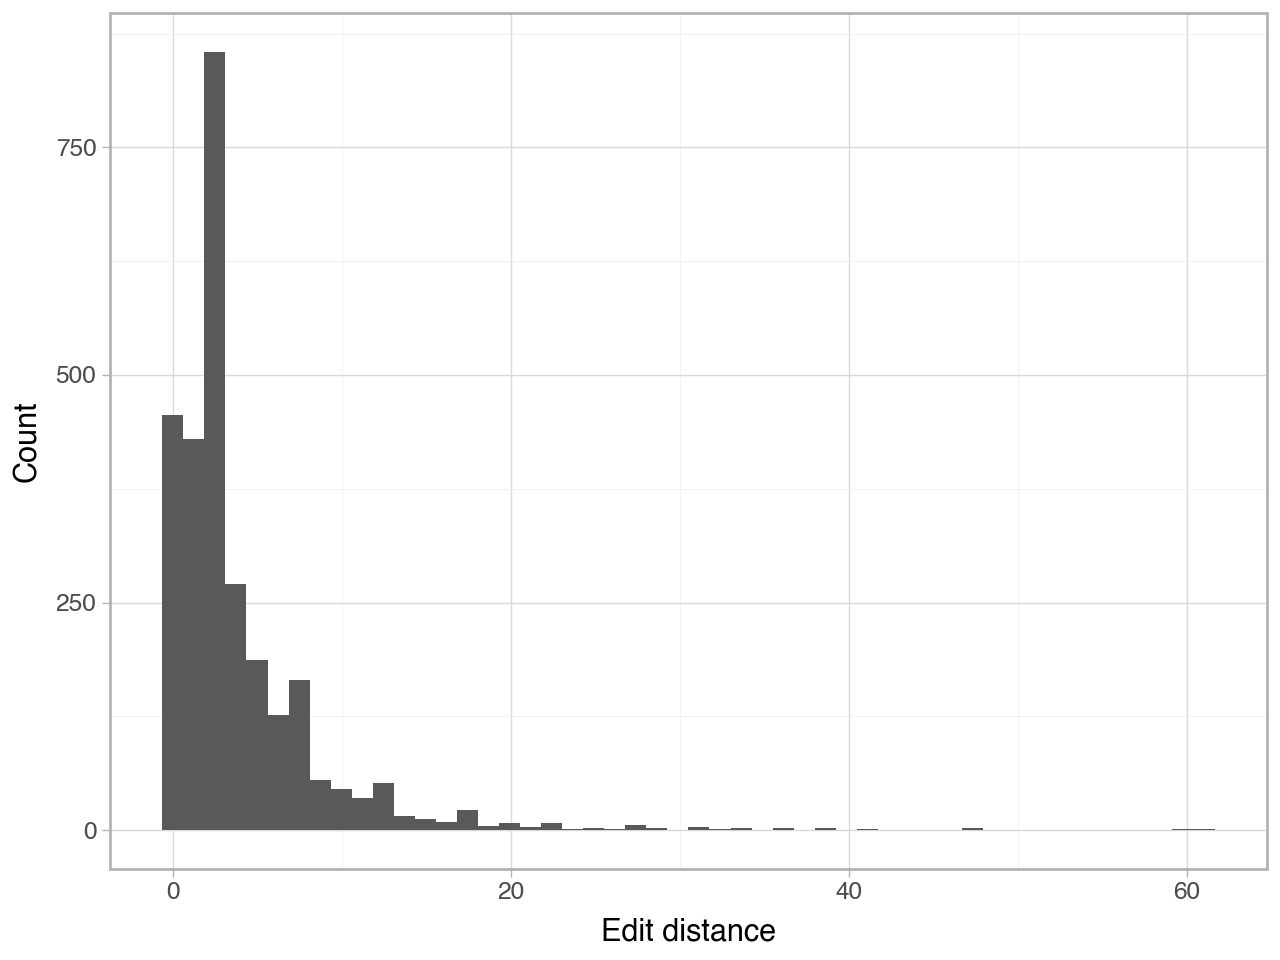

In [11]:
import plotnine as p9
# Set theme
p9.theme_set(p9.theme_light())

df = pd.DataFrame({'edit_distance': edit_distances})
p = (p9.ggplot(df, p9.aes(x='edit_distance')) +
        p9.geom_histogram(bins=50) +
        p9.xlab('Edit distance') +
        p9.ylab('Count'))
p.show()

Average normalised edit distance: 0.2400621758214503


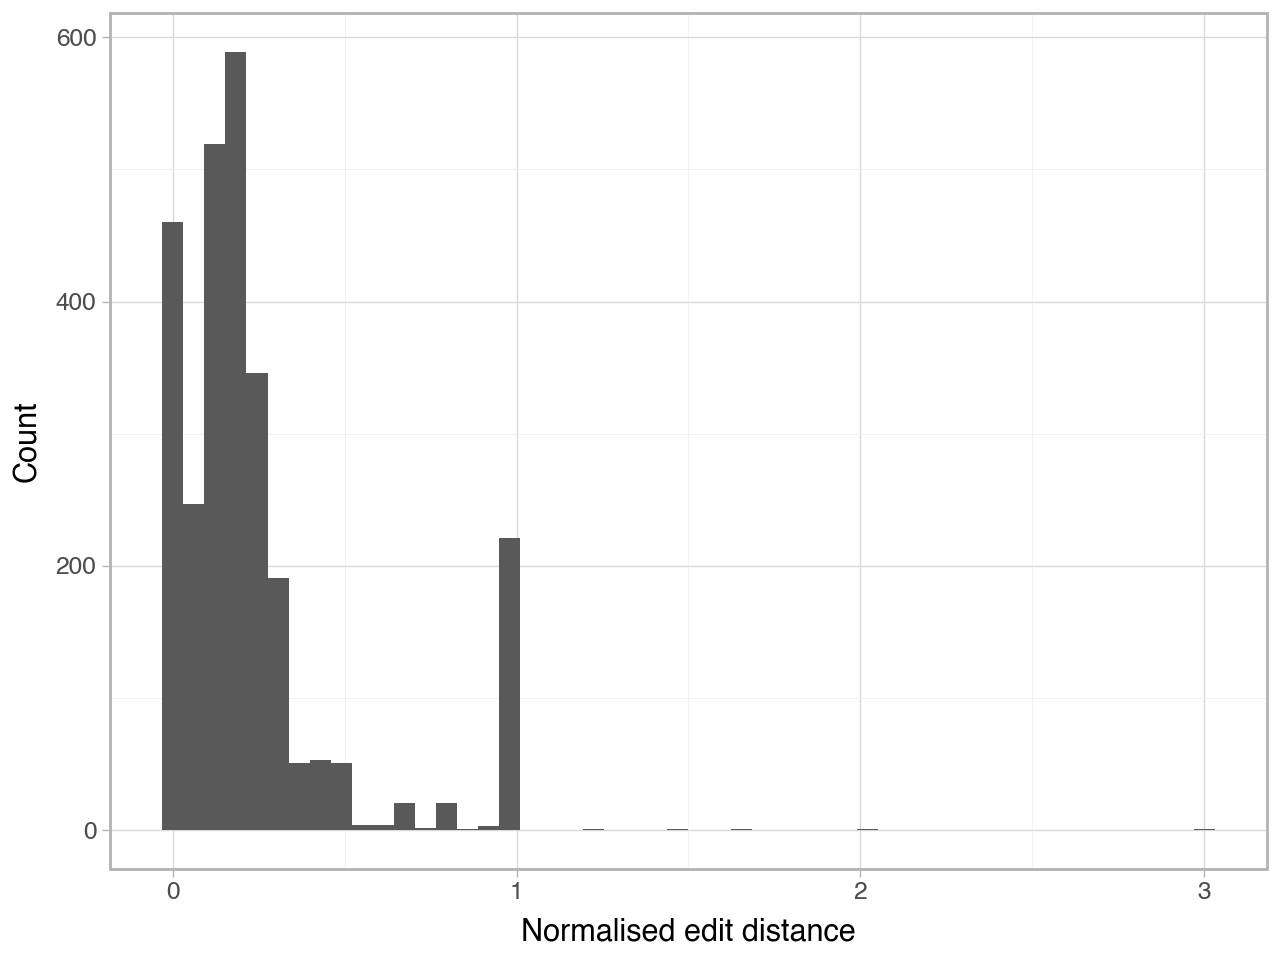

In [12]:
normalised_edit_distances = [ed/len(line.split()) for ed, line in zip(edit_distances, folded_lines_stripped[::subsample])]

print('Average normalised edit distance:', sum(normalised_edit_distances)/len(normalised_edit_distances))

df = pd.DataFrame({'normalised_edit_distance': normalised_edit_distances})
p = (p9.ggplot(df, p9.aes(x='normalised_edit_distance')) +
        p9.geom_histogram(bins=50) +
        p9.xlab('Normalised edit distance') +
        p9.ylab('Count'))
p.show()

In [13]:
# Show examples where normalised edit distance is high

high_edit_distance_indices = [i for i, ed in enumerate(normalised_edit_distances) if ed > 0.9]
print('High edit distance examples:')
for i in high_edit_distance_indices[:5]:
    print(f'Original:   {orthographic_lines[i * subsample]}')
    print(f'Folded:     {folded_lines_stripped[i * subsample]}')
    print(f'Phonemized: {phonemized_lines_stripped[i * subsample]}')
    print(f'Edit distance: {edit_distances[i]}')
    print(f'Normalised edit distance: {normalised_edit_distances[i]}')
    print()

High edit distance examples:
Original:   yeah
Folded:     j æ 
Phonemized: j e h 
Edit distance: 2
Normalised edit distance: 1.0

Original:   n'est pas
Folded:     n e pʰ ɑ: 
Phonemized: e n e s tʰ pʰ æ s 
Edit distance: 5
Normalised edit distance: 1.25

Original:   mm
Folded:     m m 
Phonemized: e m e m 
Edit distance: 2
Normalised edit distance: 1.0

Original:   mm mm
Folded:     m m m m 
Phonemized: e m e m e m e m 
Edit distance: 4
Normalised edit distance: 1.0

Original:   yeah
Folded:     j æ 
Phonemized: j e h 
Edit distance: 2
Normalised edit distance: 1.0



In [14]:
total_edit_distance = sum(edit_distances)
total_phonemes = sum([line.count(' ') for line in folded_lines_stripped[::subsample]])
print('Total edit distance:', total_edit_distance)
print('Total phonemes:', total_phonemes)
print('Average phonemes between each edit:', total_phonemes/total_edit_distance)

Total edit distance: 10807
Total phonemes: 60821
Average phonemes between each edit: 5.627926344036273


## Vocabulary analysis



In [15]:
def get_vocabulary(lines):
    vocabulary = {}
    for line in lines:
        for token in line.split():
            if not token in vocabulary:
                vocabulary[token] = 0
            vocabulary[token] += 1
    vocabulary = {k: v for k, v in sorted(vocabulary.items(), key=lambda item: item[1], reverse=True)}
    return vocabulary

phone_vocabulary = get_vocabulary(folded_lines)
phonemized_vocabulary = get_vocabulary(phonemized_lines)

unseen = phone_vocabulary.keys() - phonemized_vocabulary.keys()
unseen_counts = {phone: phone_vocabulary[phone] for phone in unseen}
unseen_counts = {k: v for k, v in sorted(unseen_counts.items(), key=lambda item: item[1], reverse=True)}
unknown = phonemized_vocabulary.keys() - phone_vocabulary.keys()
unknown_counts = {phone: phonemized_vocabulary[phone] for phone in unknown}
unknown_counts = {k: v for k, v in sorted(unknown_counts.items(), key=lambda item: item[1], reverse=True)}

print('Phonemes in folded but not phonemized:', unseen_counts)
print('Phonemes in phonemized but not folded:', unknown_counts)


Phonemes in folded but not phonemized: {'ɑ:': 121928, 'ɚ': 66118}
Phonemes in phonemized but not folded: {'i': 75731, 'ɐ': 75236, 'ɑː': 42526, 'ʊə': 2587, 'n̩': 1410, 'aː': 18, 'ɑ̃': 12, 'ɬ': 11, 'ɔ': 11, 'r': 4, 'x': 3}


In [16]:
def get_replacement_info(lines, lines2, phoneme, ignore_mismatched_words=False, context_right=False, context_left=False):
    # Note: Only finds the phonemes in the exact index in the parallel word, 
    # if there have been insertions/deletions then this will not work. Ignore these cases 
    # with ignore_mismatched_words=True (although this will still not catch all cases)
    counts = {}
    matching_words = {}
    for i, line in enumerate(lines):
        words = line.split('WORD_BOUNDARY')
        folded_words = lines2[i].split('WORD_BOUNDARY')
        if len(words) != len(folded_words):
            continue
        for j, word in enumerate(words):
            folded_word = folded_words[j]
            word = word.split()
            folded_word = folded_word.split()
            index = -1
            for k, phone in enumerate(word):
                if phone == phoneme:
                    index = k
                    break
            if index != -1:
                if (ignore_mismatched_words or len(word) == len(folded_word)) and index < len(folded_word):
                    if context_left and context_right:
                        a = ' '.join(folded_word[index-2:index+3])
                    elif context_right:
                        a = ' '.join(folded_word[index:index+3])
                    elif context_left:
                        a = ' '.join(folded_word[index-2:index+1])
                    else:
                        a = folded_word[index]
                    if not a in counts:
                        counts[a] = 0
                        matching_words[a] = {}
                    counts[a] += 1
                    orthographic_word = orthographic_lines[i].split(' ')[j] if j < len(orthographic_lines[i].split(' ')) else 'N/A'
                    if not orthographic_word in matching_words[a]:
                        matching_words[a][orthographic_word] = 0
                    matching_words[a][orthographic_word] += 1
    for a in matching_words:
        matching_words[a] = dict(sorted(matching_words[a].items(), key=lambda item: item[1], reverse=True))
    counts = dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))
    return counts, matching_words

In [17]:
print('Replacement info for phoneme "ɚ":')
counts, matching_words = get_replacement_info(folded_lines, phonemized_lines, 'ɚ')
print('Phonemes that replace "ɚ" in the automated transcription:')
print(counts)
print("\nWords that replace 'ɚ' in the automated transcription for each replaced phoneme:")
for key in matching_words:
    if counts[key] > 100:
        print(f"{key}\t{matching_words[key]}")

Replacement info for phoneme "ɚ":
Phonemes that replace "ɚ" in the automated transcription:
{'ə': 9227, 'ɜː': 6537, 'ɔː': 6117, 'ɑː': 2450, 'ɹ': 1309, 'ɪə': 359, 'ɪ': 6, 'æ': 2, 'ɐ': 1}

Words that replace 'ɚ' in the automated transcription for each replaced phoneme:
ɑː	{'are': 2440, 'hansard': 4, 'placard': 3, 'bollard': 1, 'taggart': 1, 'shephard': 1}
ɜː	{'her': 2430, 'were': 2103, 'er': 1315, 'thirteen': 128, 'homework': 63, 'herself': 52, 'hers': 49, 'research': 39, 'advert': 25, 'thirteenth': 17, 'expert': 16, 'inverse': 15, 'paperwork': 15, 'insert': 14, 'crossword': 12, 'adverts': 11, 'housework': 10, 'yogurt': 10, 'controversy': 9, 'perfect': 8, 'transfer': 8, 'blackbirds': 7, 'advertisement': 7, 'transferred': 7, 'experts': 6, 'personality': 6, 'blackbird': 6, 'hamburg': 5, 'personnel': 5, 'survey': 5, 'extroverts': 5, 'steelworks': 5, 'luxembourg': 4, 'serviettes': 4, 'kingsworth': 4, 'woodwork': 4, 'extrovert': 4, 'upturn': 3, 'wilbur': 3, 'emergency': 3, 'passwords': 3, 'co

In [18]:
for phoneme in unknown:
    if phonemized_vocabulary[phoneme] < 100:
        continue
    print('Replacement info for phoneme', phoneme)
    counts, matching_words = get_replacement_info(phonemized_lines, folded_lines, phoneme)
    print('Phonemes that replace', phoneme, 'in the true transcription:')
    print(counts)
    print("\nWords that replace", phoneme, "in the true transcription for each replaced phoneme:")
    for key in matching_words:
        if counts[key] > 100:
            print(f"{key}\t{matching_words[key]}")
    print()

Replacement info for phoneme ɐ
Phonemes that replace ɐ in the true transcription:
{'ə': 32021, 'æ': 6051, 'eɪ': 3883, 'ɑ:': 308, 'e': 11, 'ɔː': 3, 'ɪ': 2, 'pʰ': 1, 'ɚ': 1}

Words that replace ɐ in the true transcription for each replaced phoneme:
ə	{'a': 16419, 'about': 4875, 'again': 1306, 'an': 1204, 'another': 971, 'away': 882, 'than': 773, 'has': 733, 'ago': 384, 'along': 278, 'against': 193, 'allowed': 162, 'apparently': 113, 'afford': 106, 'alone': 94, 'agree': 92, 'apart': 86, 'amount': 84, 'around': 80, 'afraid': 80, 'amazing': 71, 'asleep': 67, 'caravan': 65, 'address': 56, 'admit': 52, 'america': 50, 'ahead': 47, 'banana': 44, 'hiya': 44, 'american': 41, 'that': 39, 'appointment': 34, 'agreed': 33, 'attack': 33, 'awake': 32, 'alive': 32, 'catalogue': 31, 'spaghetti': 30, 'annoying': 29, 'account': 28, 'whereabouts': 28, 'according': 28, 'pathetic': 27, 'appreciate': 27, 'bananas': 26, 'allow': 25, 'among': 25, 'magazines': 24, 'annoyed': 23, 'magazine': 22, 'bungalow': 22, 'm

In [19]:
def example_words_with_phoneme(lines, phoneme):
    examples_count = {}
    for i, line in enumerate(lines):
        words = line.split('WORD_BOUNDARY')
        for j, word in enumerate(words):
            word = word.split()
            if phoneme in word:
                example = orthographic_lines[i].split(' ')[j] if j < len(orthographic_lines[i].split(' ')) else 'N/A' + ', ' + ' '.join(word)
                examples_count[example] = examples_count.get(example, 0) + 1
    examples_count = dict(sorted(examples_count.items(), key=lambda item: item[1], reverse=True))
    return examples_count

print('Examples of words with phoneme "n̩":')
examples_count = example_words_with_phoneme(phonemized_lines, 'n̩')
print(examples_count)

Examples of words with phoneme "n̩":
{"wasn't": 1040, 'it': 27, 'i': 19, 'there': 13, 'he': 13, 'that': 10, 'the': 8, 'and': 8, 'to': 6, 'she': 6, 'you': 6, 'of': 5, 'yeah': 5, 'so': 5, 'a': 5, 'well': 4, 'then': 4, 'was': 4, 'at': 4, 'though': 3, 'one': 3, 'really': 3, 'this': 3, 'night': 3, 'in': 3, 'oh': 2, 'week': 2, 'two': 2, 'if': 2, 'thing': 2, 'kitchen': 2, 'where': 2, 'we': 2, 'his': 2, 'out': 2, 'have': 2, 'name': 2, 'know': 2, 'b': 2, "that's": 2, 'on': 2, 'but': 2, 'they': 2, 'mm': 2, 'him': 2, 'end': 2, 'like': 2, 'bloody': 2, 'warmer': 1, 'shocker': 1, 'because': 1, 'exam': 1, 'pound': 1, 'hill': 1, 'part': 1, 'doing': 1, 'test': 1, 'evidently': 1, 'gas': 1, 'hundred': 1, 'best': 1, 'old': 1, 'when': 1, 'through': 1, 'originally': 1, 'which': 1, 'had': 1, 'tape': 1, 'small': 1, 'liked': 1, 'buy': 1, 'goal': 1, 'car': 1, 'sit': 1, 'alex': 1, 'obviously': 1, 'down': 1, 'poo': 1, 'story': 1, 'us': 1, 'over': 1, 'nothing': 1, 'run': 1, 'concern': 1, 'north': 1, 'yellow': 1, '

## Vocabulary agreement comparison

Now we look at the shared vocabulary of both transcriptions, the phone symbols that they both use, as although these may be shared, they may not be used in the same places.

In [20]:
def get_phoneme_agreement(lines1, lines2, phoneme, ignore_mismatched_words=False):
    # For a particular phoneme, finds matches in each line and produces
    # a dictionary of counts for the phonemes aligned in the opposite line.
    # Note that this assumes that the phoneme is in the same position in both lines, 
    # which may not be the case if there are insertions/deletions. We can ignore these cases
    # by setting ignore_mismatched_words=True but this will still not catch all cases.
    matches1 = {}
    matches2 = {}
    for i, (line1, line2) in enumerate(zip(lines1, lines2)):
        words1 = line1.split('WORD_BOUNDARY')
        words2 = line2.split('WORD_BOUNDARY')
        if len(words1) != len(words2):
            continue
        for (word1, word2) in zip(words1, words2):
            word1 = word1.split()
            word2 = word2.split()
            if ignore_mismatched_words and len(word1) != len(word2):
                continue
            for k in range(len(word1)):
                if word1[k] == phoneme and k < len(word2):
                    matched_phoneme = word2[k]
                    matches1[matched_phoneme] = matches1.get(matched_phoneme, 0) + 1
            for k in range(len(word2)):
                if word2[k] == phoneme and k < len(word1):
                    matched_phoneme = word1[k]
                    matches2[matched_phoneme] = matches2.get(matched_phoneme, 0) + 1
    matches1 = dict(sorted(matches1.items(), key=lambda item: item[1], reverse=True))
    matches2 = dict(sorted(matches2.items(), key=lambda item: item[1], reverse=True))
    return matches1, matches2

def get_percentage_agreement(lines1, lines2, phoneme, ignore_mismatched_words=False):
    # For a particular phoneme, count the percentage of times the phoneme
    # is used in the same position in both lines
    total = 0
    agreement = 0
    matches1, matches2 = get_phoneme_agreement(lines1, lines2, phoneme, ignore_mismatched_words)
    agreement += matches1.get(phoneme, 0)
    agreement += matches2.get(phoneme, 0)
    total += sum(matches1.values())
    total += sum(matches2.values())
    return agreement/total if total > 0 else None

shared_dict = phone_vocabulary.keys() & phonemized_vocabulary.keys()
for phoneme in shared_dict:
    agreement = get_percentage_agreement(folded_lines, phonemized_lines, phoneme)
    agr_str = f'{agreement:.2f}' if agreement is not None else 'N/A'
    print(f'Agreement for phoneme {phoneme}: {agr_str}')


Agreement for phoneme ɒ: 0.08
Agreement for phoneme ɪə: 0.40
Agreement for phoneme ɔː: 0.69
Agreement for phoneme eɪ: 0.90
Agreement for phoneme iː: 0.79
Agreement for phoneme d: 0.97
Agreement for phoneme əʊ: 0.96
Agreement for phoneme d̠ʒ: 0.98
Agreement for phoneme aɪ: 0.99
Agreement for phoneme j: 0.99
Agreement for phoneme z: 0.93
Agreement for phoneme ʃ: 0.97
Agreement for phoneme ŋ: 0.95
Agreement for phoneme tʰ: 0.97
Agreement for phoneme f: 0.99
Agreement for phoneme æ: 0.72
Agreement for phoneme n: 0.94
Agreement for phoneme s: 0.97
Agreement for phoneme t̠ʃ: 0.91
Agreement for phoneme θ: 0.96
Agreement for phoneme aʊ: 0.98
Agreement for phoneme ʒ: 0.92
Agreement for phoneme v: 1.00
Agreement for phoneme uː: 0.91
Agreement for phoneme ɔɪ: 1.00
Agreement for phoneme WORD_BOUNDARY: N/A
Agreement for phoneme ɪ: 0.68
Agreement for phoneme ɜː: 0.74
Agreement for phoneme ʌ: 0.69
Agreement for phoneme ɹ: 0.89
Agreement for phoneme w: 0.93
Agreement for phoneme b: 0.99
Agreement for 

In [21]:
agreements = {}
for phoneme in shared_dict:
    agreement = get_percentage_agreement(folded_lines, phonemized_lines, phoneme, ignore_mismatched_words=True)
    agr_str = f'{agreement:.2f}' if agreement is not None else 'N/A'
    print(f'Agreement for phoneme {phoneme}: {agr_str}')
    if agreement is not None:
        agreements[phoneme] = agreement

Agreement for phoneme ɒ: 0.08
Agreement for phoneme ɪə: 0.59
Agreement for phoneme ɔː: 0.70
Agreement for phoneme eɪ: 0.93
Agreement for phoneme iː: 0.81
Agreement for phoneme d: 1.00
Agreement for phoneme əʊ: 0.97
Agreement for phoneme d̠ʒ: 0.99
Agreement for phoneme aɪ: 0.99
Agreement for phoneme j: 1.00
Agreement for phoneme z: 0.97
Agreement for phoneme ʃ: 1.00
Agreement for phoneme ŋ: 0.97
Agreement for phoneme tʰ: 1.00
Agreement for phoneme f: 1.00
Agreement for phoneme æ: 0.83
Agreement for phoneme n: 0.99
Agreement for phoneme s: 0.98
Agreement for phoneme t̠ʃ: 1.00
Agreement for phoneme θ: 0.97
Agreement for phoneme aʊ: 0.99
Agreement for phoneme ʒ: 0.89
Agreement for phoneme v: 1.00
Agreement for phoneme uː: 0.94
Agreement for phoneme ɔɪ: 1.00
Agreement for phoneme WORD_BOUNDARY: N/A
Agreement for phoneme ɪ: 0.70
Agreement for phoneme ɜː: 0.77
Agreement for phoneme ʌ: 0.71
Agreement for phoneme ɹ: 0.98
Agreement for phoneme w: 1.00
Agreement for phoneme b: 1.00
Agreement for 

In [22]:
low_agreement_phonemes = {k: v for k, v in agreements.items() if v < 0.8}
low_agreement_phonemes = dict(sorted(low_agreement_phonemes.items(), key=lambda item: item[1]))
for phoneme in low_agreement_phonemes:
    print(f'Phoneme {phoneme} has low agreement ({low_agreement_phonemes[phoneme]:.2f})')

Phoneme ɒ has low agreement (0.08)
Phoneme ə has low agreement (0.48)
Phoneme ɪə has low agreement (0.59)
Phoneme ʊ has low agreement (0.65)
Phoneme ɪ has low agreement (0.70)
Phoneme ɔː has low agreement (0.70)
Phoneme ʌ has low agreement (0.71)
Phoneme ɜː has low agreement (0.77)


In [23]:
for phoneme in low_agreement_phonemes.keys():
    print('-'*20)
    print('Replacement info for phoneme', phoneme)
    total_phonemized = sum([line.count(phoneme) for line in phonemized_lines])
    total_folded = sum([line.count(phoneme) for line in folded_lines])
    print('Total phonemes in phonemized orthographic:', total_phonemized)
    print('Total phonemes in folded phonemic:', total_folded)

    counts, matching_words = get_replacement_info(phonemized_lines, folded_lines, phoneme)
    print('Phonemes that replace', phoneme, 'in the true transcription:')
    print(counts)
    print("\nWords that replace", phoneme, "in the true transcription:")
    for key in matching_words:
        if counts[key] > 100:
            print(f"{key}\t{matching_words[key]}")

    counts, matching_words = get_replacement_info(folded_lines, phonemized_lines, phoneme)
    print('Phonemes that replace', phoneme, 'in the automated transcription:')
    print(counts)
    print("\nWords that replace", phoneme, "in the automated transcription:")
    for key in matching_words:
        if counts[key] > 100:
            print(f"{key}\t{matching_words[key]}")    
    print()

--------------------
Replacement info for phoneme ɒ
Total phonemes in phonemized orthographic: 210798
Total phonemes in folded phonemic: 13112
Phonemes that replace ɒ in the true transcription:
{'ɑ:': 39636, 'ɔː': 23762, 'ʌ': 22862, 'ə': 17197, 'ɒ': 4508, 'ʊ': 2107, 'əʊ': 587, 'w': 15, 'æ': 13, 'uː': 6, 'ɹ': 1}

Words that replace ɒ in the true transcription:
ɑ:	{'got': 7943, 'on': 7366, 'not': 6021, 'want': 3160, 'lot': 1135, 'was': 874, 'god': 643, 'sorry': 493, 'stop': 426, 'tomorrow': 422, 'watch': 371, 'wants': 302, 'top': 296, 'john': 260, "o'clock": 248, 'shop': 230, 'box': 229, 'everybody': 191, 'hot': 190, 'problem': 184, 'coffee': 178, 'job': 166, 'lots': 141, 'bottom': 133, 'shopping': 126, 'holiday': 123, 'wash': 118, 'washing': 117, 'watching': 117, 'cost': 116, 'drop': 115, 'probably': 105, 'stopped': 92, 'forgot': 77, 'gosh': 76, 'odd': 71, 'watched': 68, 'shops': 66, 'knock': 65, 'bother': 64, 'properly': 64, 'pop': 61, 'college': 61, 'jonathan': 60, 'socks': 59, 'dogs'

In [43]:
def find_phonemes_for_word(word):
    phonemes = {}
    for i in range(len(orthographic_lines)):
        line = str(orthographic_lines[i])
        words = line.split(' ')
        for j, orth_word in enumerate(words):
            if orth_word == word:
                phonemic_words = phonemic_lines[i].split(' WORD_BOUNDARY ')[:-1]
                if len(phonemic_words) != len(words):
                    continue
                phonemic_word = phonemic_words[j]
                if not phonemic_word in phonemes:
                    phonemes[phonemic_word] = 0
                phonemes[phonemic_word] += 1
    return phonemes

find_phonemes_for_word('there')

{'ð ɛ ə': 7004, 'ð ɛ r': 4856, 'b aɪ': 1}